

> ### ***Import Necessary Libraries*** ###



In [1]:
! pip install tensorflow==2.9.1

  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached google_auth-2.40.3-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached oauthlib-3.3.1-py3-none-any.whl.metadata (7.9 kB)
   ---------------------------------------- 0.0/444.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/444.0 MB ? eta -:--:--
   ---------------------------------------- 1.6/444.0 MB 6.0 MB/s eta 0:01:14
   ---------------------------------------- 3.4/444.0 MB 7.2 MB/s eta 0:01:02
   ---------------------------------------- 4.2/444.0 MB 7.4 MB/s eta 0:01:00
   ---------------------------------------- 4.2/444.0 MB 7.4 MB/s eta 0:01:00
    --------------------------------------- 6.3/444.0 MB 5.8 MB/s eta 0:01:1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.24.0 requires protobuf<5,>=3.20, but you have protobuf 3.19.6 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import system libraries
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# Import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

# Import deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

Modules loaded




> ### ***Data Preprocessing*** ###



In [4]:
# Custom callback for learning rate warmup
class LRScheduler(tf.keras.callbacks.Callback):
    def __init__(self, start_lr, end_lr, warmup_epochs):
        super(LRScheduler, self).__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.warmup_epochs = warmup_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            lr = self.start_lr + (self.end_lr - self.start_lr) * (epoch / self.warmup_epochs)
            self.model.optimizer.learning_rate.assign(lr)

In [5]:
# Read data and store in dataframe
data_dir = r'D:\Abdelraouf\Quran\Training_Program\test\archive\brain_tumor_dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

In [6]:
df

,filepaths,labels
0,D:\Abdelraouf\Quran\Training_Program\test\arch...,no
1,D:\Abdelraouf\Quran\Training_Program\test\arch...,no
2,D:\Abdelraouf\Quran\Training_Program\test\arch...,no
3,D:\Abdelraouf\Quran\Training_Program\test\arch...,no
4,D:\Abdelraouf\Quran\Training_Program\test\arch...,no
...,...,...
248,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
249,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
250,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
251,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes


In [7]:
df.head()

,filepaths,labels
0,D:\Abdelraouf\Quran\Training_Program\test\arch...,no
1,D:\Abdelraouf\Quran\Training_Program\test\arch...,no
2,D:\Abdelraouf\Quran\Training_Program\test\arch...,no
3,D:\Abdelraouf\Quran\Training_Program\test\arch...,no
4,D:\Abdelraouf\Quran\Training_Program\test\arch...,no


In [8]:
df.tail()

,filepaths,labels
248,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
249,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
250,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
251,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
252,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes


In [9]:
df.sample(10)

,filepaths,labels
182,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
172,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
167,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
107,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
248,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
139,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
197,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
13,D:\Abdelraouf\Quran\Training_Program\test\arch...,no
217,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes
207,D:\Abdelraouf\Quran\Training_Program\test\arch...,yes




> ### ***Split data into train, valid, and test*** ###



In [10]:
strat = df['labels']
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

In [11]:
# Compute class weights for imbalanced dataset
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['labels']),
    y=train_df['labels']
)
class_weights_dict = dict(enumerate(class_weights))



> ### ***Create image data generators*** ###



In [12]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    shear_range=0.05,
    brightness_range=[0.95, 1.05],
    fill_mode='nearest'
)
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.




> ### ***Show sample from train data*** ###



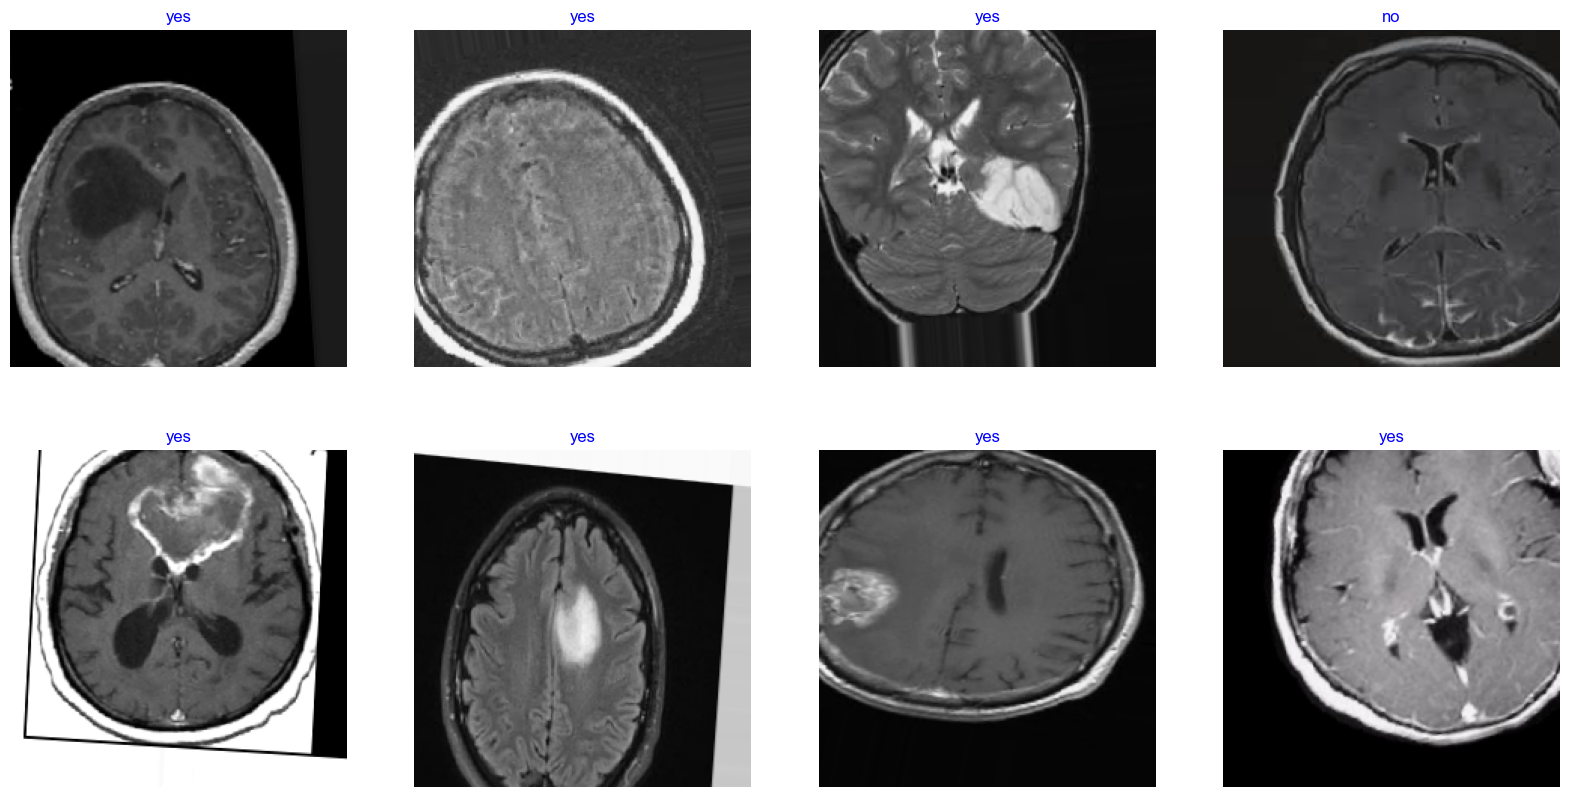

In [13]:
g_dict = train_gen.class_indices  # Dictionary {'class': index}
classes = list(g_dict.keys())     # List of class names
images, labels = next(train_gen)  # Get a batch of samples

plt.figure(figsize=(20, 10))
for i in range(min(8, len(images))):  # Ensure we don't exceed batch size
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255  # Scale data to range (0 - 1)
    plt.imshow(image)
    index = int(labels[i])  # Integer labels for sparse class mode
    class_name = classes[index]  # Get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()



> ### ***Define ResNet101 model*** ###



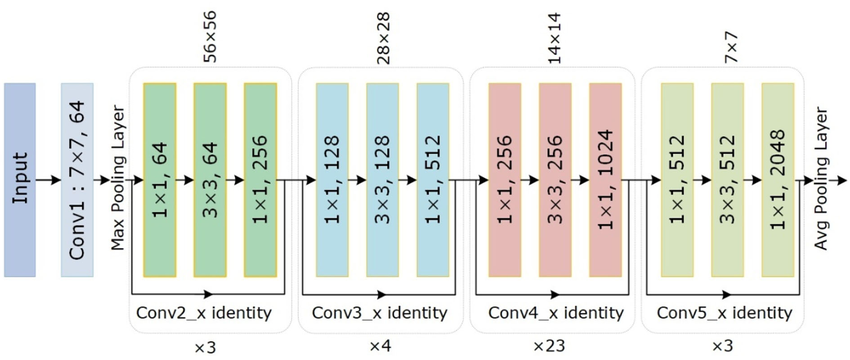

In [14]:
# Define ResNet101 model
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

# Freeze all layers initially
base_model.trainable = False

# Unfreeze the last 15 layers for fine-tuning
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Build model
model = Sequential([
    base_model,
    Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.7),
    Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
], name='ResNet101')

In [15]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.00005, clipnorm=1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "ResNet101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                         



> ### ***Train Model*** ###



In [16]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
warmup_scheduler = LRScheduler(start_lr=1e-5, end_lr=0.00005, warmup_epochs=5)

In [17]:
# Train model with callbacks and class weights
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=test_gen,
    verbose=1,
    callbacks=[early_stop, lr_scheduler, checkpoint, warmup_scheduler],
    class_weight=class_weights_dict
)

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.5644 - accuracy: 0.5248
Epoch 1: val_accuracy improved from -inf to 0.70588, saving model to best_model.h5
13/13 [==============================] - 36s 2s/step - loss: 1.5644 - accuracy: 0.5248 - val_loss: 1.0861 - val_accuracy: 0.7059 - lr: 1.0000e-05
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 1.5947 - accuracy: 0.5248
Epoch 2: val_accuracy did not improve from 0.70588
13/13 [==============================] - 24s 2s/step - loss: 1.5947 - accuracy: 0.5248 - val_loss: 1.0641 - val_accuracy: 0.7059 - lr: 1.8000e-05
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 1.6048 - accuracy: 0.4950
Epoch 3: val_accuracy did not improve from 0.70588
13/13 [==============================] - 23s 2s/step - loss: 1.6048 - accuracy: 0.4950 - val_loss: 1.0470 - val_accuracy: 0.7059 - lr: 2.6000e-05
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 1.5443 - accuracy: 0.5396
E



> ### ***Display model performance*** ###



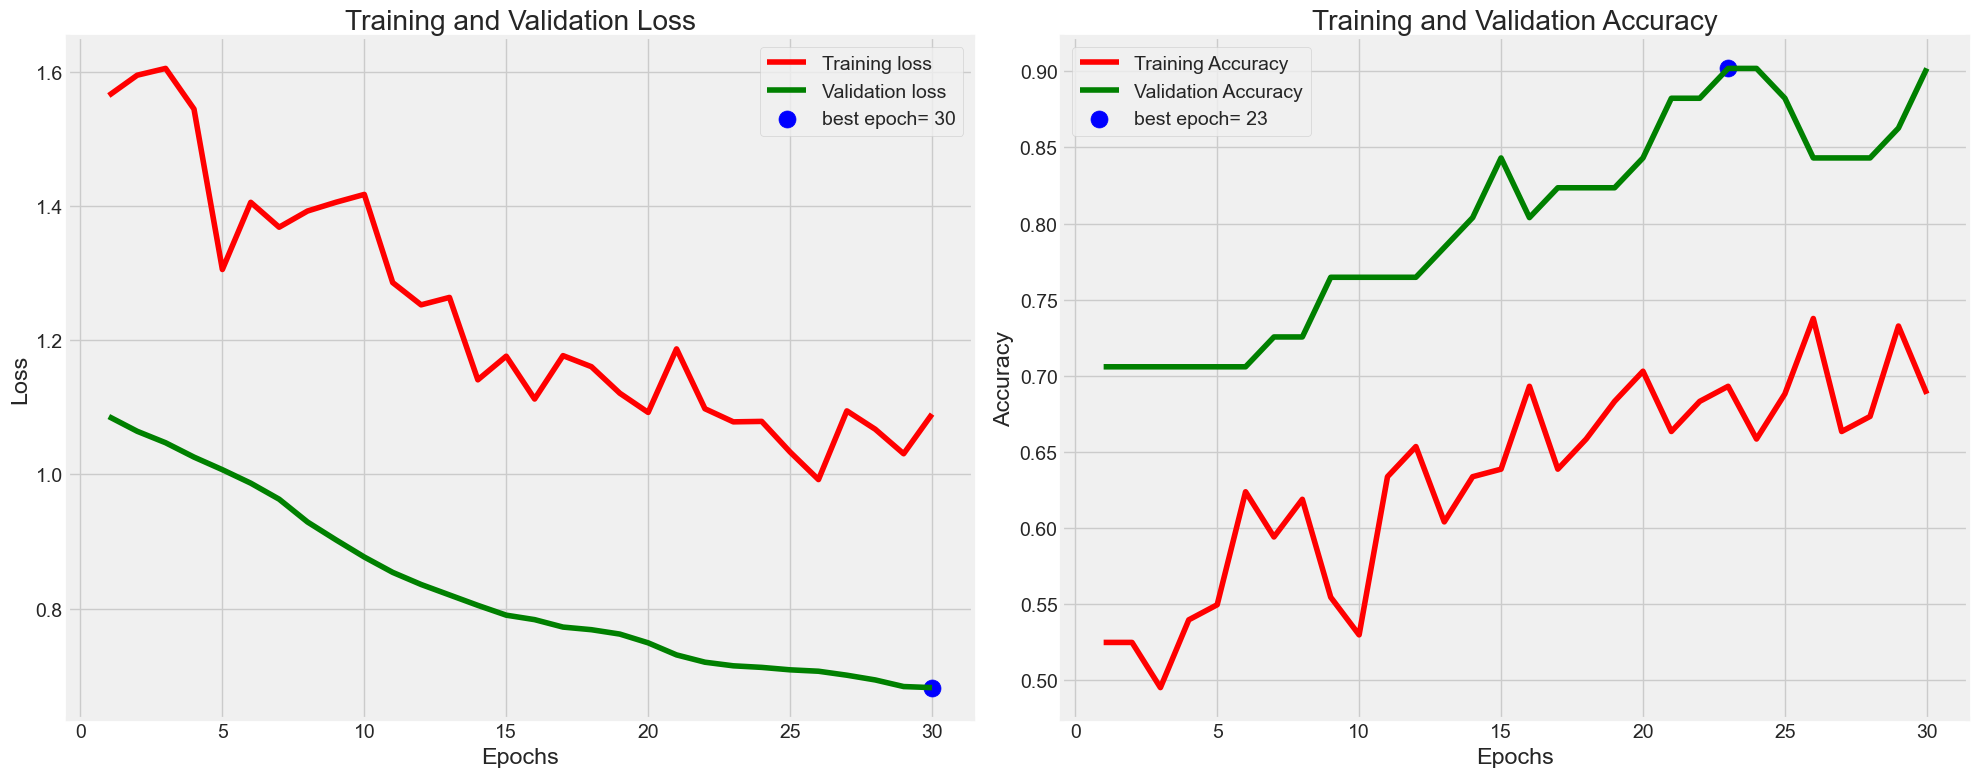

In [18]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



> ### ***Evaluate model*** ###



In [19]:
train_score = model.evaluate(train_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 [==============================] - 6s 1s/step - loss: 0.6822 - accuracy: 0.9020
Train Loss:  0.7073923945426941
Train Accuracy:  0.8910890817642212
--------------------
Test Loss:  0.6821821331977844
Test Accuracy:  0.9019607901573181




> ### ***Generate predictions*** ###



In [20]:
y_pred = np.argmax(model.predict(test_gen), axis=1)

4/4 [==============================] - 8s 1s/step




> ### ***Confusion Matrix*** ###



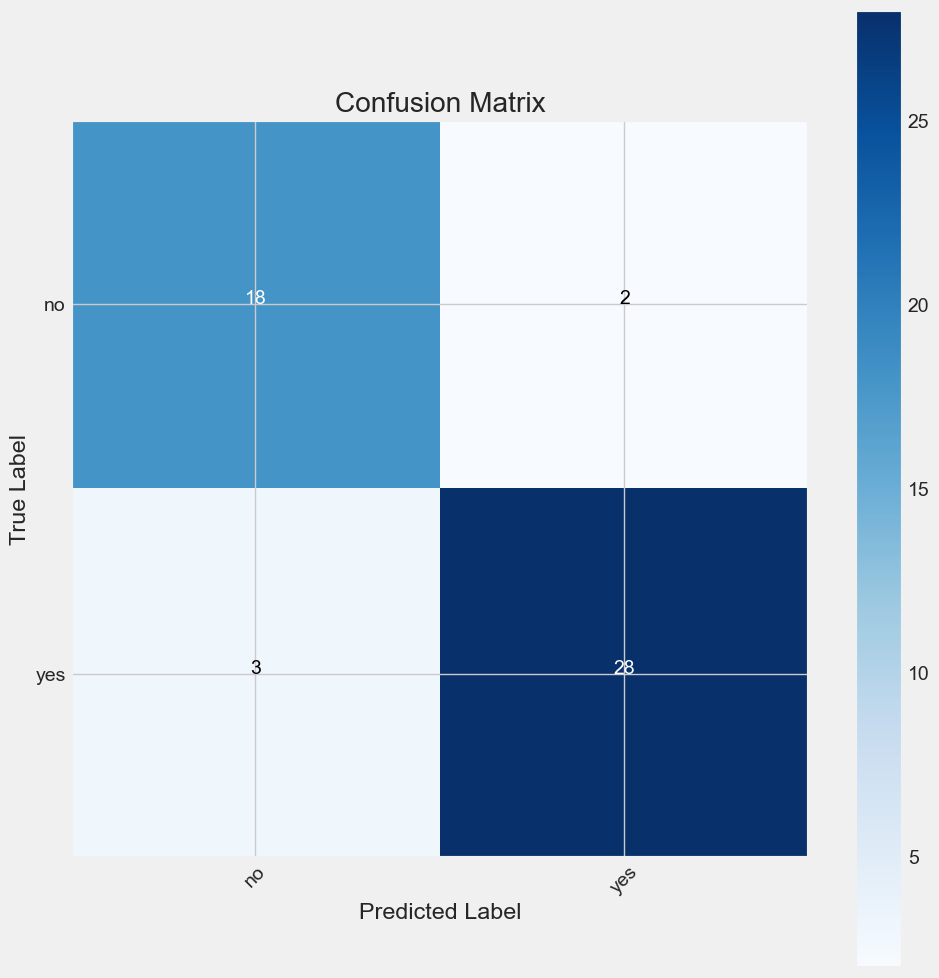

In [21]:
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



> ### ***Classification report*** ###



In [22]:
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

          no       0.86      0.90      0.88        20
         yes       0.93      0.90      0.92        31

    accuracy                           0.90        51
   macro avg       0.90      0.90      0.90        51
weighted avg       0.90      0.90      0.90        51





> ### ***Predict and display 5 sample images from test set*** ###



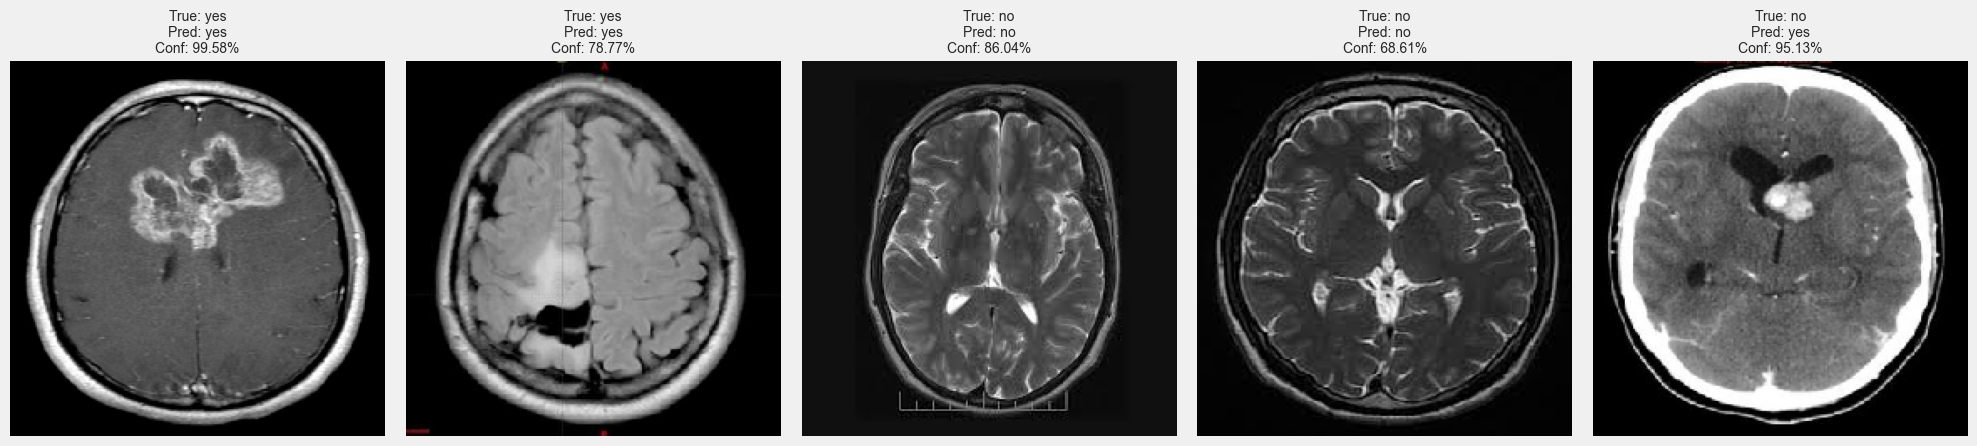

In [23]:
test_gen.reset()  # Reset generator to start
images, true_labels = next(test_gen)  # Get a batch of test images and labels
sample_indices = np.random.choice(len(images), 5, replace=False)  # Select 5 random indices

plt.figure(figsize=(20, 5))
for i, idx in enumerate(sample_indices):
    image = images[idx] / 255  # Scale image
    true_label = int(true_labels[idx])  # True label (integer)
    true_class = classes[true_label]  # True class name

    # Predict
    pred_probs = model.predict(np.expand_dims(images[idx], axis=0), verbose=0)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = classes[pred_label]
    confidence = np.max(pred_probs) * 100  # Confidence score in percentage

    # Plot image
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}%', fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()



> ### ***Save the model*** ###



In [ ]:
model.save('best_model.h5')